# Import Library & Data


In [ ]:
!pip install transformers==4.30.2
!pip install sastrawi

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from tqdm import tqdm
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.utils import simple_preprocess
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import random
from collections import defaultdict
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
import matplotlib.pyplot as plt
import multiprocessing

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

!gdown 1hcRlndDFoPgqID3mtcCZfR2PlxwSGDeW

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.0 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Downloading...
From: https://drive.google.com/uc?id=1hcRlndDFoPgqID3mtcCZfR2PlxwSGDeW
To: /content/dataset (6).xlsx
100% 18.6M/18.6M [00:00<00:00, 44.0MB/s]


device(type='cuda', index=0)

In [ ]:
df = pd.read_excel('/content/dataset (6).xlsx')
df

,Unnamed: 0,Headline,Link,Content,Label,contentp,HeadlineContent,HeadlineContentp
0,0,\n\n\t\t\t\t\t[SALAH] AKUN WHATSAPP SEKRETARIS...,https://turnbackhoax.id/2024/02/02/salah-akun-...,Akun tersebut PALSU. Hal ini telah diklarifika...,Hoax,PENJELASAN: Beredar sebuah pesan berantai What...,\n\n\t\t\t\t\t[SALAH] AKUN WHATSAPP SEKRETARIS...,\n\n\t\t\t\t\t[SALAH] AKUN WHATSAPP SEKRETARIS...
1,1,\n\n\t\t\t\t\t[SALAH] Gambar Anies dengan Nara...,https://turnbackhoax.id/2024/02/02/salah-gamba...,Hasil Periksa Fakta Luthfiyah\nGambar Anies me...,Hoax,PENJELASAN:Akun Facebook Andi Zzh memposting s...,\n\n\t\t\t\t\t[SALAH] Gambar Anies dengan Nara...,\n\n\t\t\t\t\t[SALAH] Gambar Anies dengan Nara...
2,2,\n\n\t\t\t\t\t[SALAH] Video Dukungan Prabowo K...,https://turnbackhoax.id/2024/02/02/salah-video...,Hasil Periksa Fakta Luthfiyah\nVideo yang dikl...,Hoax,PENJELASAN:Akun Tik Tok subyan4800480184417 me...,\n\n\t\t\t\t\t[SALAH] Video Dukungan Prabowo K...,\n\n\t\t\t\t\t[SALAH] Video Dukungan Prabowo K...
3,3,\n\n\t\t\t\t\t[SALAH] Gambar Gibran pada Artik...,https://turnbackhoax.id/2024/02/02/salah-gamba...,Hasil Periksa Fakta Luthfiyah\nGambar Gibran p...,Hoax,PENJELASAN:Akun Facebook Jiro Lu Pat mempostin...,\n\n\t\t\t\t\t[SALAH] Gambar Gibran pada Artik...,\n\n\t\t\t\t\t[SALAH] Gambar Gibran pada Artik...
4,4,\n\n\t\t\t\t\t[SALAH] Video Jokowi Memerintahk...,https://turnbackhoax.id/2024/01/31/salah-video...,Hasil periksa fakta Rahmah an.\nKlaim Presiden...,Hoax,[PENJELASAN]:Beredar sebuah video di Youtube S...,\n\n\t\t\t\t\t[SALAH] Video Jokowi Memerintahk...,\n\n\t\t\t\t\t[SALAH] Video Jokowi Memerintahk...
...,...,...,...,...,...,...,...,...
17703,17703,"Anies Janjikan Program Bansos Plus, Bantuan Di...",https://nasional.tempo.co/read/1815177/anies-j...,"TEMPO.CO,Jakarta-Calon presiden nomor urut 1,A...",nonHoax,"TEMPO.CO,Jakarta-Calon presiden nomor urut 1,A...","Anies Janjikan Program Bansos Plus, Bantuan Di...","Anies Janjikan Program Bansos Plus, Bantuan Di..."
17704,17704,Soal Laporan Akhir Tahun Dugaan Kecurangan Pem...,https://nasional.tempo.co/read/1815166/soal-la...,"TEMPO.CO,Jakarta- Deputi Hukum Tim Pemenangan ...",nonHoax,"TEMPO.CO,Jakarta- Deputi Hukum Tim Pemenangan ...",Soal Laporan Akhir Tahun Dugaan Kecurangan Pem...,Soal Laporan Akhir Tahun Dugaan Kecurangan Pem...
17705,17705,Anies Baswedan Sebut Pemerintah Selama Ini Tak...,https://nasional.tempo.co/read/1815162/anies-b...,"TEMPO.CO,Jakarta-Calon presiden nomor urut 1An...",nonHoax,"TEMPO.CO,Jakarta-Calon presiden nomor urut 1An...",Anies Baswedan Sebut Pemerintah Selama Ini Tak...,Anies Baswedan Sebut Pemerintah Selama Ini Tak...
17706,17706,"Kasus Surat Suara PPLN Taipei, TPN Ganjar-Mahf...",https://nasional.tempo.co/read/1815155/kasus-s...,"TEMPO.CO,Jakarta- Deputi Hukum Tim Pemenangan ...",nonHoax,"TEMPO.CO,Jakarta- Deputi Hukum Tim Pemenangan ...","Kasus Surat Suara PPLN Taipei, TPN Ganjar-Mahf...","Kasus Surat Suara PPLN Taipei, TPN Ganjar-Mahf..."


#PREPROCESSING DATA

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.dropna(inplace=True)

In [ ]:
import re
stopword = StopWordRemoverFactory().create_stop_word_remover()
id_sw = set(stopwords.words('indonesian'))
id_sw.discard('tidak')
adt_sw = ['salah', "klarifikasi", "disinformasi", "cekfakta", "hasil", "periksa","fakta",
          "baca","juga","tempo","penjelasan","jakarta","facebook","twitter","tik","tok",
          "tiktok","memposting","mengunggah","youtube","https","http","www","gseehttps","id", "bit","ly",
          "google","translate","mxvn","com","co","cnn","kompas","read", "formula", "cnnindonesia",
          "page", "news","permalink", "youtu", "be", "ioyc", "referensi", "index", "html", "watch", "hoaks"]
stop_words = id_sw.union(set(adt_sw))

def stopwordSastrawi(text):
    return stopword.remove(text)

def regex(text):
    text = text.lower()
    text = re.sub(r'[^.,a-zA-Z0-9 \n\.]',' ',text) #remove symbol
    text = re.sub('[\s]+', ' ', text) #menghilangkan additional whitespace
    text = re.sub(r'[^\w\s]','',text) #remove punctuation
    text = text.strip() #menghilangkan enter, tab, dll
    return text

def addt_stop_word(sentence):
    words = word_tokenize(sentence)
    return ''.join(' '.join(w for w in words if not w.lower() in stop_words))

def all_preproc(input_data):
    preproc = list(map(regex, input_data.values))
    # preproc = list(map(stopwordSastrawi, tqdm(preproc)))
    preproc = list(map(addt_stop_word, tqdm(preproc)))
    return preproc

In [ ]:
df['Content'] = df['HeadlineContentp'].astype(str).apply(lambda x: ' '.join(simple_preprocess(x)))
df

,Unnamed: 0,Headline,Link,Content,Label,contentp,HeadlineContent,HeadlineContentp
0,0,\n\n\t\t\t\t\t[SALAH] AKUN WHATSAPP SEKRETARIS...,https://turnbackhoax.id/2024/02/02/salah-akun-...,salah akun whatsapp sekretaris daerah pekalong...,Hoax,PENJELASAN: Beredar sebuah pesan berantai What...,\n\n\t\t\t\t\t[SALAH] AKUN WHATSAPP SEKRETARIS...,\n\n\t\t\t\t\t[SALAH] AKUN WHATSAPP SEKRETARIS...
1,1,\n\n\t\t\t\t\t[SALAH] Gambar Anies dengan Nara...,https://turnbackhoax.id/2024/02/02/salah-gamba...,salah gambar anies dengan narasi untuk semua p...,Hoax,PENJELASAN:Akun Facebook Andi Zzh memposting s...,\n\n\t\t\t\t\t[SALAH] Gambar Anies dengan Nara...,\n\n\t\t\t\t\t[SALAH] Gambar Anies dengan Nara...
2,2,\n\n\t\t\t\t\t[SALAH] Video Dukungan Prabowo K...,https://turnbackhoax.id/2024/02/02/salah-video...,salah video dukungan prabowo kepada anies pilp...,Hoax,PENJELASAN:Akun Tik Tok subyan4800480184417 me...,\n\n\t\t\t\t\t[SALAH] Video Dukungan Prabowo K...,\n\n\t\t\t\t\t[SALAH] Video Dukungan Prabowo K...
3,3,\n\n\t\t\t\t\t[SALAH] Gambar Gibran pada Artik...,https://turnbackhoax.id/2024/02/02/salah-gamba...,salah gambar gibran pada artikel berjudul perk...,Hoax,PENJELASAN:Akun Facebook Jiro Lu Pat mempostin...,\n\n\t\t\t\t\t[SALAH] Gambar Gibran pada Artik...,\n\n\t\t\t\t\t[SALAH] Gambar Gibran pada Artik...
4,4,\n\n\t\t\t\t\t[SALAH] Video Jokowi Memerintahk...,https://turnbackhoax.id/2024/01/31/salah-video...,salah video jokowi memerintahkan untuk stop ba...,Hoax,[PENJELASAN]:Beredar sebuah video di Youtube S...,\n\n\t\t\t\t\t[SALAH] Video Jokowi Memerintahk...,\n\n\t\t\t\t\t[SALAH] Video Jokowi Memerintahk...
...,...,...,...,...,...,...,...,...
17703,17703,"Anies Janjikan Program Bansos Plus, Bantuan Di...",https://nasional.tempo.co/read/1815177/anies-j...,anies janjikan program bansos plus bantuan dis...,nonHoax,"TEMPO.CO,Jakarta-Calon presiden nomor urut 1,A...","Anies Janjikan Program Bansos Plus, Bantuan Di...","Anies Janjikan Program Bansos Plus, Bantuan Di..."
17704,17704,Soal Laporan Akhir Tahun Dugaan Kecurangan Pem...,https://nasional.tempo.co/read/1815166/soal-la...,soal laporan akhir tahun dugaan kecurangan pem...,nonHoax,"TEMPO.CO,Jakarta- Deputi Hukum Tim Pemenangan ...",Soal Laporan Akhir Tahun Dugaan Kecurangan Pem...,Soal Laporan Akhir Tahun Dugaan Kecurangan Pem...
17705,17705,Anies Baswedan Sebut Pemerintah Selama Ini Tak...,https://nasional.tempo.co/read/1815162/anies-b...,anies baswedan sebut pemerintah selama ini tak...,nonHoax,"TEMPO.CO,Jakarta-Calon presiden nomor urut 1An...",Anies Baswedan Sebut Pemerintah Selama Ini Tak...,Anies Baswedan Sebut Pemerintah Selama Ini Tak...
17706,17706,"Kasus Surat Suara PPLN Taipei, TPN Ganjar-Mahf...",https://nasional.tempo.co/read/1815155/kasus-s...,kasus surat suara ppln taipei tpn ganjar mahfu...,nonHoax,"TEMPO.CO,Jakarta- Deputi Hukum Tim Pemenangan ...","Kasus Surat Suara PPLN Taipei, TPN Ganjar-Mahf...","Kasus Surat Suara PPLN Taipei, TPN Ganjar-Mahf..."


In [ ]:
df['Content'] = all_preproc(df['Content'])
df.head(10)

100%|██████████| 17675/17675 [00:32<00:00, 539.79it/s]


,Unnamed: 0,Headline,Link,Content,Label,contentp,HeadlineContent,HeadlineContentp
0,0,\n\n\t\t\t\t\t[SALAH] AKUN WHATSAPP SEKRETARIS...,https://turnbackhoax.id/2024/02/02/salah-akun-...,akun whatsapp sekretaris daerah pekalongan don...,Hoax,PENJELASAN: Beredar sebuah pesan berantai What...,\n\n\t\t\t\t\t[SALAH] AKUN WHATSAPP SEKRETARIS...,\n\n\t\t\t\t\t[SALAH] AKUN WHATSAPP SEKRETARIS...
1,1,\n\n\t\t\t\t\t[SALAH] Gambar Anies dengan Nara...,https://turnbackhoax.id/2024/02/02/salah-gamba...,gambar anies narasi pendukung lupa coblos no p...,Hoax,PENJELASAN:Akun Facebook Andi Zzh memposting s...,\n\n\t\t\t\t\t[SALAH] Gambar Anies dengan Nara...,\n\n\t\t\t\t\t[SALAH] Gambar Anies dengan Nara...
2,2,\n\n\t\t\t\t\t[SALAH] Video Dukungan Prabowo K...,https://turnbackhoax.id/2024/02/02/salah-video...,video dukungan prabowo anies pilpres akun suby...,Hoax,PENJELASAN:Akun Tik Tok subyan4800480184417 me...,\n\n\t\t\t\t\t[SALAH] Video Dukungan Prabowo K...,\n\n\t\t\t\t\t[SALAH] Video Dukungan Prabowo K...
3,3,\n\n\t\t\t\t\t[SALAH] Gambar Gibran pada Artik...,https://turnbackhoax.id/2024/02/02/salah-gamba...,gambar gibran artikel berjudul perkosa kambing...,Hoax,PENJELASAN:Akun Facebook Jiro Lu Pat mempostin...,\n\n\t\t\t\t\t[SALAH] Gambar Gibran pada Artik...,\n\n\t\t\t\t\t[SALAH] Gambar Gibran pada Artik...
4,4,\n\n\t\t\t\t\t[SALAH] Video Jokowi Memerintahk...,https://turnbackhoax.id/2024/01/31/salah-video...,video jokowi memerintahkan stop bantuan rohing...,Hoax,[PENJELASAN]:Beredar sebuah video di Youtube S...,\n\n\t\t\t\t\t[SALAH] Video Jokowi Memerintahk...,\n\n\t\t\t\t\t[SALAH] Video Jokowi Memerintahk...
5,5,\n\n\t\t\t\t\t[SALAH] Puluhan Menteri Kabinet ...,https://turnbackhoax.id/2024/01/31/salah-puluh...,puluhan menteri kabinet jokowi mundur ikuti la...,Hoax,[PENJELASAN]:\nKanal Youtube Redaksi TV mengun...,\n\n\t\t\t\t\t[SALAH] Puluhan Menteri Kabinet ...,\n\n\t\t\t\t\t[SALAH] Puluhan Menteri Kabinet ...
6,6,\n\n\t\t\t\t\t[SALAH] Hasil Persidangan Terbuk...,https://turnbackhoax.id/2024/01/31/salah-hasil...,persidangan terbukti ijazah jokowi palsu akun ...,Hoax,[PENJELASAN]:\nAkun Twitter/X @Wiparayudha men...,\n\n\t\t\t\t\t[SALAH] Hasil Persidangan Terbuk...,\n\n\t\t\t\t\t[SALAH] Hasil Persidangan Terbuk...
7,7,\n\n\t\t\t\t\t[SALAH] Akun WhatsApp Kepala Dis...,https://turnbackhoax.id/2024/01/31/salah-akun-...,akun whatsapp kepala diskominfo kota banjar de...,Hoax,PENJELASAN:Beredar akun Kepala Diskominfo Kota...,\n\n\t\t\t\t\t[SALAH] Akun WhatsApp Kepala Dis...,\n\n\t\t\t\t\t[SALAH] Akun WhatsApp Kepala Dis...
8,8,\n\n\t\t\t\t\t[SALAH] Partai Buruh Deklarasika...,https://turnbackhoax.id/2024/01/31/salah-parta...,partai buruh deklarasikan anies baswedan kanal...,Hoax,[PENJELASAN]:\nKanal Youtube GARUDA POLITIK me...,\n\n\t\t\t\t\t[SALAH] Partai Buruh Deklarasika...,\n\n\t\t\t\t\t[SALAH] Partai Buruh Deklarasika...
9,9,\n\n\t\t\t\t\t[SALAH] Akun WhatsApp Pj Bupati ...,https://turnbackhoax.id/2024/01/31/salah-akun-...,akun whatsapp pj bupati bangkalan arief edie k...,Hoax,PENJELASAN: Beredar akun WhatsApp dengan nomor...,\n\n\t\t\t\t\t[SALAH] Akun WhatsApp Pj Bupati ...,\n\n\t\t\t\t\t[SALAH] Akun WhatsApp Pj Bupati ...


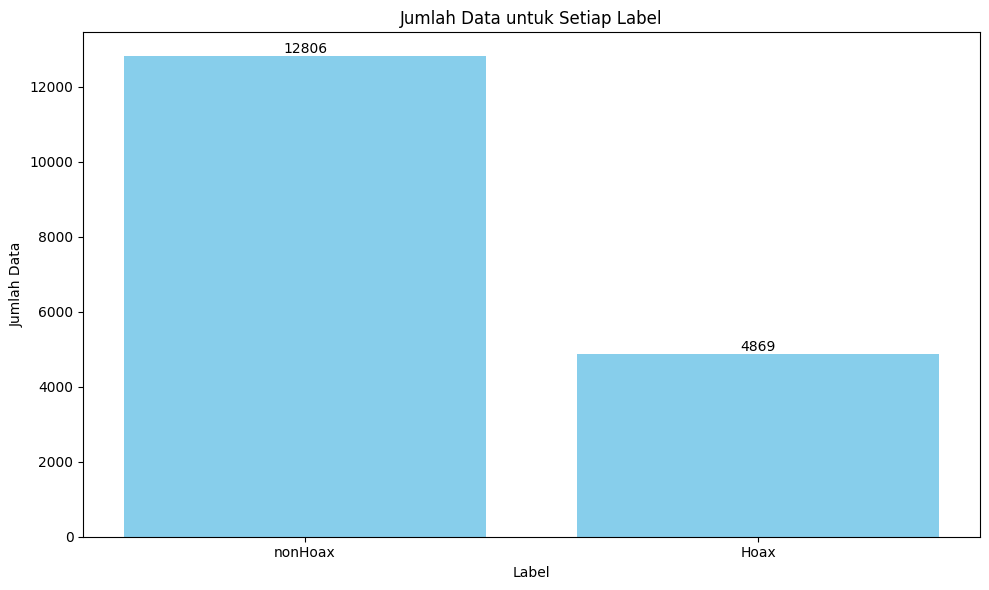

In [ ]:
# Hitung jumlah data untuk setiap label
label_counts = df['Label'].value_counts()


# Buat bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(label_counts.index, label_counts, color='skyblue')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')
plt.title('Jumlah Data untuk Setiap Label')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')

# Menambahkan label pada sumbu x
plt.tight_layout()

# Tampilkan plot
plt.show()

# TRAINING DATA

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["Label"] = label_encoder.fit_transform(df["Label"])
np.save('bert_classes.npy', label_encoder.classes_)

In [ ]:
PRE_TRAINED_MODEL_NAME = 'indobenchmark/indobert-base-p2'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [ ]:
token_lens = []

for txt in df.Content:
  tokenize = tokenizer.tokenize(txt)
  tokens = tokenizer.encode(txt)
  token_lens.append(len(tokens))

max_token_length = max(token_lens)
print("Maximum Token Length:", max_token_length)

Maximum Token Length: 2503


In [ ]:
token_ids = tokenizer.convert_tokens_to_ids(tokenize)
print("Token IDs:", token_ids)

Token IDs: [29712, 7383, 1788, 7932, 14003, 18905, 9162, 11283, 19044, 3823, 3298, 3425, 30370, 2120, 2304, 3150, 7383, 29712, 74, 2493, 775, 16957, 17472, 10816, 2304, 7338, 1772, 14003, 3320, 2038, 15994, 25951, 1288, 4678, 11283, 27908, 19044, 3823, 24521, 2398, 55, 24521, 29712, 3980, 8736, 1602, 4581, 7932, 14003, 26857, 29712, 15349, 7932, 14003, 11376, 507, 104, 6378, 19044, 9050, 33, 11040, 2304, 3749, 8259, 868, 2304, 868, 11376, 11283, 19044, 3823, 17472, 10816, 14003, 2413, 11283, 19044, 3823, 2075, 1783, 10816, 14003, 2040, 2413, 11283, 19044, 3823, 29712, 3401, 4829, 3253, 1217, 2713, 2546, 14003, 22640, 10816, 14003, 8093, 15349, 3320, 11283, 19044, 3823, 555, 2933, 27878, 4683, 1511, 3953, 2713, 2546, 14003, 2505, 3022, 6139, 6810, 5098, 12278, 14003, 14899, 16750, 17863, 25382, 95, 7932, 14003, 15712, 3667, 26246, 8818, 3834, 24588, 27951, 15349, 8454, 2120, 511, 6343, 1287, 4896, 30355, 11283, 19044, 3823, 27205, 30355, 1906, 53, 1038, 30356, 14003, 13145, 4627, 2038, 

In [ ]:
MAX_LEN = 512

In [ ]:
class GPNewsContentDataset(Dataset):

  def __init__(self, news_contents, targets, tokenizer, max_len):
    self.news_contents = news_contents
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.news_contents)

  def __getitem__(self, item):
    news_content = str(self.news_contents[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      news_content,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True,
    )

    return {
      'news_content_text': news_content,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size,shuffle=True):
  ds = GPNewsContentDataset(
    news_contents=df.Content.to_numpy(),
    targets=df.Label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=1
  )

In [ ]:
BATCH_SIZE = 8
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE, shuffle=True)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE, shuffle=True)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE,shuffle=True)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


dict_keys(['news_content_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

In [ ]:
class LabelClassifier(nn.Module):

  def __init__(self, n_classes):
    super(LabelClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)


  def forward(self, input_ids, attention_mask):
    pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output[1])
    return self.out(output)

In [ ]:
model = LabelClassifier(2)
model = model.to(device)

In [ ]:
EPOCHS = 3
optimizer = optim.SGD(model.parameters(), lr=5e-5, momentum=0.9)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'content_skripsi.bin')
    best_accuracy = val_acc

Epoch 1/3
----------
Train loss 0.49809941500678184 accuracy 0.7495049504950495
Val   loss 0.3186073428635144 accuracy 0.8964346349745331

Epoch 2/3
----------
Train loss 0.22205541714419066 accuracy 0.9257425742574257
Val   loss 0.12264373051887589 accuracy 0.9558573853989814

Epoch 3/3
----------
Train loss 0.13258105378816057 accuracy 0.9532531824611032
Val   loss 0.09751117346825171 accuracy 0.966044142614601



In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9666289592760182

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  news_content_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["news_content_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      news_content_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return news_content_texts, predictions, prediction_probs, real_values

In [ ]:
y_news_content_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
ypred = label_encoder.inverse_transform(y_pred)
ytest = label_encoder.inverse_transform(y_test)

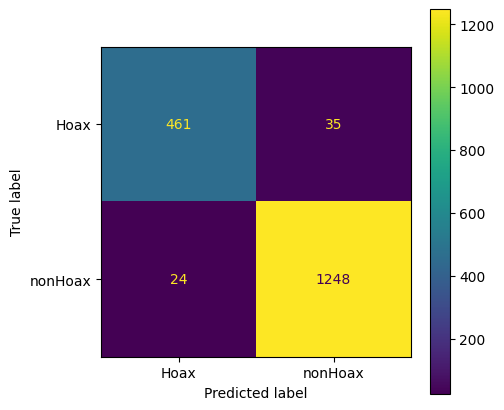

In [ ]:
from matplotlib.pyplot import figure

cm = confusion_matrix(ytest, ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = label_encoder.classes_)
plt.rcParams["figure.figsize"] = (5,5)
disp.plot()
plt.show()

In [ ]:
# prompt: make a dataframe for data that false positves in the confusion matrix

import pandas as pd
import numpy as np
# Get indices of false positives
fp_indices = (ypred == 'nonHoax') & (ytest == 'nonHoax')

# Create a DataFrame for false positives
fp_df = pd.DataFrame({
    'Text': np.array(y_news_content_texts)[fp_indices],
    'Predicted Label': ypred[fp_indices],
    'True Label': ytest[fp_indices]
})

fp_df.to_excel('tn.xlsx')


In [ ]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

        Hoax       0.95      0.93      0.94       496
     nonHoax       0.97      0.98      0.98      1272

    accuracy                           0.97      1768
   macro avg       0.96      0.96      0.96      1768
weighted avg       0.97      0.97      0.97      1768



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/content_skripsi(8 - 3e-5).bin')

In [ ]:
# prompt: make a df for data train,val test import it in excel

import pandas as pd

# Create dataframes for train, validation, and test sets
df_train = pd.DataFrame(df_train)
df_val = pd.DataFrame(df_val)
df_test = pd.DataFrame(df_test)

# Export dataframes to Excel files
df_train.to_excel('/content/train.xlsx', index=False)
df_val.to_excel('/content/val.xlsx', index=False)
df_test.to_excel('/content/test.xlsx', index=False)


In [ ]:
# prompt: please predict this text with this model and the same preprocess
# Jakarta, CNN Indonesia -- Anggota Komisi II DPR dari Fraksi Partai Keadilan Sejahtera (PKS), Mardani Ali Sera mengusulkan agar keluarga inti Presiden dilarang menduduki jabatan publik yang dipilih melalui mekanisme pemilu.Lewat akun Twitter-nya, pernyataan itu disampaikan Mardani merespons kabar ketertarikan putra bungsu Presiden

# Preprocess the text
text = text = """
SALAH] “Pidato Sang Gubernur Sumut Edy Rahmayadi, serukan JIHAD dan Revolusi terhadap Rezim Busuk!”
Bukan pidato Gubernur Edy Rahmayadi. Kalimat di klaim tersebut berasal dari Ustaz Heriansyah dari GNPF Ulama Sumut yang disampaikan pada bulan Mei 2019.
Selengkapnya di bagian PENJELASAN dan REFERENSI============================================Kategori : Konten yang Menyesatkan ============================================
Akun Iskandariah Harahapll (fb.com/iskandariah.harahapll) mengunggah foto Gubernur Sumatera Utara Edy Rahmayadi dengan narasi sebagai berikut:
“MERINDING!! GUBERNUR SUMUT SERUKAN JIHAD DAN REVOLUSI!! TEGASKAN BAHWA REZIM INI ADALAH REZIM BUSUK!Gubernur Sumut, Letnan Jenderal Purnawirawan TNI H. Edy Rahmayadi, serukan JIHAD dan Revolusi terhadap Rezim Busuk!Pidato Sang Gubernur yang dekat dengan ulama ini begitu membakar masa.===============================“Kita tidak bisa dikalahkan dengan senjata-senjata yang dihadapkan kepada kita. Maka saya ingin menyampaikan kepada Bapa-Bapa TNI, kepada Bapa-Bapa Polisi, BERPIHAKLAH kepada rakyat. Karena siapapun yang jadi Presiden kalian tetap polisi. Kalian tetap tentara.”“TNI, TNI kalian telah membuat pilihan yang benar.”“Tapi Kepada polisi, kepada polisi, Anda saudara kami, Anda keluarga kami, Anda mungkin juga tetangga kami, Anda mungkin bahkan jamaah pengajian saya, TAPI REZIM ini, TELAH MEMBUAT ANDA DIBENCI OLEH RAKYAT. Rezim ini yang SALAH. Rezim ini yang keliru bukan Anda. Tapi karena KEBUSUKAN REZIM INI maka Anda DIBENCI OLEH RAKYAT. Warna pakaian Anda bahkan menjadi warna yang dibenci oleh semua orang. Maka berpihaklah pada rakyat”
Selengkapnya di https://archive.md/SckDX (Arsip)============================================
PENJELASAN
Berdasarkan hasil penelusuran, klaim adanya pidato dari Gubernur Sumatera Utara Edy Rahmayadi yang menyerukan jihad dan revolusi terhadap rezim busuk adalah klaim yang salah.
Faktanya, bukan pidato Gubernur Edy Rahmayadi. Kalimat di klaim tersebut berasal dari Ustaz Heriansyah dari GNPF Ulama Sumut yang disampaikan pada bulan Mei 2019.
Dikutip dari artikel berjudul “[SALAH] Gubernur Sumut, Edy Rahmayadi, serukan JIHAD dan Revolusi terhadap Rezim Busuk”, Pemerintah Provinsi Sumatera Utara pun telah memberikan bantahan secara resmi terkait video yang menyebut Gubernur Sumut Edy Rahmayadi menyerukan jihad dan revolusi.
“Pemprov Sumut memastikan suara pria dalam video tersebut bukan suara Gubernur Edy Rahmayadi. Seruan jihad dan revolusi yang mengatasnamakan Gubernur Edy Rahmayadi itu adalah hoaks,” kata Kepala Bagian Humas Pemprov Sumut Muhammad Ikhsan kepada Tempo pada Jumat, 27 September 2019.
Ikhsan menuturkan video itu adalah video lama yang diambil pada Mei 2019 usai pemilihan presiden. “Sekitar Mei 2019 dan sudah pernah dibantah oleh Pak Edy Rahmayadi. Kenapa bisa muncul lagi? Pemprov Sumut mohon video itu tidak dipercaya dan mohon bantahan ini disebarluaskan,” ujar Ikhsan. Menurut Ikhsan, suara pria dalam video itu sudah pernah diklarifikasi. Suara itu merupakan suara Ustaz Heriansyah dari GNPF Ulama.
Bantahan ini disampaikan juga melalui akun media sosial Humas Sumatera Utara.
“Dihimbau agar seluruh masyarakat lebih berhati hati dalam menerima dan menyebarkan berita dan informasi yang tidak benar atau hoax, Gubernur Edy Rahmayadi tidak pernah mengeluarkan pernyataan jihad dan revolusi seperti akun di bawah ini.mari lebih bijak dalam menggunakan dan menyebarluaskan informasi” tulis akun Humas Sumut pada 29 September 2020.
"""
text = re.sub(r'[^.,a-zA-Z0-9 \n\.]',' ',text) #remove symbol
text = re.sub('[\s]+', ' ', text) #menghilangkan additional whitespace
text = re.sub(r'[^\w\s]','',text) #remove punctuation
text = text.strip() #menghilangkan enter, tab, dll
text = stopwordSastrawi(text)
text = addt_stop_word(text)

# Tokenize the text
tokens = tokenizer.encode(text)

# Create a tensor for the input IDs
input_ids = torch.tensor(tokens).unsqueeze(0)

# Create a tensor for the attention mask
attention_mask = torch.ones_like(input_ids)

# Move the tensors to the device
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)

# Get the model's predictions
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    _, preds = torch.max(outputs, dim=1)

# Move the predictions to CPU and convert to a NumPy array
preds = preds.cpu().numpy()  # Move to CPU before converting

# Decode the predictions
predicted_class = label_encoder.inverse_transform(preds)

# Print the predicted class
print(predicted_class[0])

Hoax
